In [37]:
import pandas as pd

df_wine = pd.read_csv(
    'data/wine.data',
    header=None
)

In [38]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

In [39]:
# Standardize the features
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [40]:
import numpy as np

cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('Eigenvalues: ')
print(eigen_vals)

Eigenvalues: 
[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


In [41]:
# Exlained variance
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
var_exp

[0.3695146859960762,
 0.1843492705988419,
 0.11815159094596996,
 0.07334251763785454,
 0.06422107821731679,
 0.050517244849076624,
 0.03954653891241442,
 0.026439183169220053,
 0.023893192591852914,
 0.016296137737251023,
 0.013800211221948423,
 0.01172226244308596,
 0.00820608567909137]

In [42]:
cum_var_exp = np.cumsum(var_exp)
cum_var_exp

array([0.36951469, 0.55386396, 0.67201555, 0.74535807, 0.80957914,
       0.86009639, 0.89964293, 0.92608211, 0.9499753 , 0.96627144,
       0.98007165, 0.99179391, 1.        ])

In [43]:
# Construct the projection matrix W 

# First we make a list of (eigenvalue, eigenvector) pairs
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
                for i in range(len(eigen_vals))]

In [44]:
# Sort the pairs from high to low
eigen_pairs.sort(key=lambda k: -k[0])


In [45]:
eigen_pairs[0][1]

array([-0.13724218,  0.24724326, -0.02545159,  0.20694508, -0.15436582,
       -0.39376952, -0.41735106,  0.30572896, -0.30668347,  0.07554066,
       -0.32613263, -0.36861022, -0.29669651])

In [46]:
eigen_pairs[0][1][:, np.newaxis]

array([[-0.13724218],
       [ 0.24724326],
       [-0.02545159],
       [ 0.20694508],
       [-0.15436582],
       [-0.39376952],
       [-0.41735106],
       [ 0.30572896],
       [-0.30668347],
       [ 0.07554066],
       [-0.32613263],
       [-0.36861022],
       [-0.29669651]])

In [47]:
# Choose top 2 eigenpairs
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))

print('Matrix W:\n', w)

Matrix W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


In [48]:
# Transform 13-dim example to 2-dim
X_train_std[0].dot(w)

array([2.38299011, 0.45458499])

In [49]:
# Transform entire training dataset
X_train_pca = X_train_std.dot(w)

In [50]:
# Using sklearns built in PCA
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')

# Dimensionality reduction
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# Fitting the logistic regression model on the reduced dataset:
lr.fit(X_train_pca, y_train)


LogisticRegression(multi_class='ovr', random_state=1)

In [52]:
from sklearn.metrics import accuracy_score

y_pred = lr.predict(X_test_pca)
accuracy_score(y_pred, y_test)

0.9259259259259259

In [53]:
# Show explained variance ratio
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

In [54]:
# Accessing feature contributions
loadings = eigen_vecs * np.sqrt(eigen_vals)

In [59]:
loadings[:, 0]

array([-0.3020184 ,  0.54408942, -0.05600938,  0.45540829, -0.33970111,
       -0.8665386 , -0.9184327 ,  0.67279444, -0.67489496,  0.16623657,
       -0.71769524, -0.81117245, -0.65291742])

In [60]:
sklearn_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

In [61]:
sklearn_loadings[:, 0]

array([-0.3020184 ,  0.54408942, -0.05600938,  0.45540829, -0.33970111,
       -0.8665386 , -0.9184327 ,  0.67279444, -0.67489496,  0.16623657,
       -0.71769524, -0.81117245, -0.65291742])

### Supervised data compression via linear discriminant analysis

In [62]:
# Goal of LDA is to find the feature subspace that optimizes class seperability

# First compute the mean vectors
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(
        X_train_std[y_train == label], axis=0 # row-wise mean
    ))
    print(f'MV {label}: {mean_vecs[label-1]}\n')


MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



In [63]:
d = 13  # Number of features
S_W = np.zeros((d, d))

for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter

In [64]:
print('Within-class scatter matrix: ', f'{S_W.shape[0]}x{S_W.shape[1]}')

Within-class scatter matrix:  13x13


In [69]:
# But the above only holds when the classes are uniformly distirbuted which is NOT the case in our dataset:
np.bincount(y_train)[1:]

array([41, 50, 33])

In [70]:
# So we need to scale it which turns out is equivalent to computing the covariance matrix (see book)
d = 13  # Number of features
S_W = np.zeros((d, d))

for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter

print('Within-class scatter matrix: ', f'{S_W.shape[0]}x{S_W.shape[1]}')

Within-class scatter matrix:  13x13


In [75]:
X_train_std[y_train == 1, :].shape[0]

41

In [76]:
# Compute the between class scatter matrix
m= np.mean(X_train_std, axis=0)
m.reshape(d, 1)

d = 13
S_B = np.zeros((d, d))
for i, mv in enumerate(mean_vecs):
    label = i + 1
    n = X_train_std[y_train == label].shape[0]
    mv = mv.reshape(d, 1)  # make into column vector
    S_B += n * (mv - m).dot((mv - m).T)

In [78]:
print('Between-class scatter matrix: ', f'{S_B.shape[0]}x{S_B.shape[1]}')

Between-class scatter matrix:  13x13


In [79]:
eigen_vals, eigen_vecs =\
    np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [80]:
# Sort the eigenvalues
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

In [81]:
eigen_pairs.sort(key=lambda x: -x[0])
print('Eigenvalues in descending order:')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:
4545.031515777923
2245.8997884673204
9.567859712868437e-13
3.913813121771452e-13
3.913813121771452e-13
2.5264326998553025e-13
1.5061811252533795e-13
1.5061811252533795e-13
1.0776570905878178e-13
8.831441708994457e-14
8.831441708994457e-14
2.7614698410823634e-14
0.0


In [82]:
# Create transformation matrix

w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
               eigen_pairs[1][1][:, np.newaxis].real))

print('Matrix W:\n', w)

Matrix W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


In [83]:
X_train_lda = X_train_std.dot(w)

In [84]:
X_train_lda.shape

(124, 2)

In [88]:
# Using sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_lda, y_train)
y_pred = lr.predict(X_train_lda)
y_pred

array([3, 1, 1, 1, 3, 2, 2, 3, 2, 2, 2, 1, 2, 3, 1, 3, 2, 1, 3, 3, 2, 1,
       2, 2, 2, 2, 3, 1, 2, 2, 1, 1, 3, 1, 2, 1, 1, 2, 3, 3, 1, 3, 3, 3,
       1, 2, 3, 3, 2, 3, 2, 2, 2, 1, 2, 2, 3, 3, 2, 1, 1, 2, 3, 3, 2, 1,
       2, 2, 2, 1, 1, 1, 1, 1, 3, 1, 2, 3, 2, 2, 3, 1, 2, 1, 2, 2, 3, 2,
       1, 1, 1, 3, 2, 1, 1, 2, 2, 3, 3, 2, 1, 1, 2, 2, 3, 1, 3, 1, 2, 2,
       2, 2, 1, 3, 1, 1, 1, 1, 2, 2, 3, 3, 2, 2])

In [94]:
accuracy_score(y_pred, y_train)

1.0

### Nonlinear Dim Red and Visualization

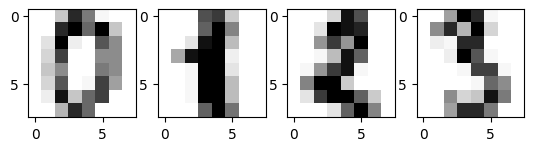

In [1]:
# t-SNE
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

digits = load_digits()

fig, ax = plt.subplots(1, 4)
for i in range(4):
    ax[i].imshow(digits.images[i], cmap='Greys')
plt.show()

In [3]:
digits.data.shape

(1797, 64)

In [4]:
y_digits = digits.target
X_digits = digits.data

In [5]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='pca', random_state=123)
X_digits_tsne = tsne.fit_transform(X_digits)